In [1]:
import sys,os
import subprocess
import numpy as np
import pylab as py
import sympy as sp
from sympy.printing.mathml import print_mathml,mathml
from sympy.parsing.sympy_parser import parse_expr
from sympy.tensor.array import MutableDenseNDimArray as Array
sp.init_printing() 
from IPython.display import display, Math, Latex
lprint=lambda expression: display(Math(sp.latex(expression)))

In [2]:
class Vec(object): 

    def __init__(self,symbol,rep='LC',mod=[1,1,1,1],theta=None):
        if rep=='LC': self.vec=self.LC(symbol,mod=mod,theta=theta)
        if rep=='MC': self.vec=self.MC(symbol,mod=mod,theta=theta)
        self.rep=rep

    def __add__(self,other):
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i]+other.vec[i] for i in range(len(other.vec))]
        return dum

    def __sub__(self,other):
        #print self.vec
        #print other.vec
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i]-other.vec[i] for i in range(len(other.vec))]
        return dum

    def __eq__(self,other):
        dum=Vec('dum',self.rep)
        dum.vec=[self.vec[i] for i in range(len(other.vec))]
        return dum
 
    def __mul__(self,other):
        if isinstance(other, Vec): 
            return self.dot(other.vec,self.vec)
        else:
            dum=Vec('dum',self.rep)
            dum.vec=[other*self.vec[i] for i in range(len(self.vec))]
            return dum
        
    def __rmul__(self,other):
        if isinstance(other, Vec): 
            return self.dot(other.vec,self.vec)
        else:
            dum=Vec('dum',self.rep)
            dum.vec=[other*self.vec[i] for i in range(len(self.vec))]
            return dum
        
    def LC(self,symbol,mod=[1,1,1,1],theta=None):
        p=sp.S('%s_p'%symbol)
        m=sp.S('%s_m'%symbol)
        t=sp.symbols('%s_t'%symbol,positive = True, real = True)
        if theta==None: theta=sp.S('theta_%s'%symbol)
        vec=[p,m,t*sp.cos(theta),t*sp.sin(theta)]
        self.p=p
        self.m=m
        self.t=t
        return [vec[i]*mod[i] for i in range(4)]
    
    def MC(self,symbol,mod=[1,1,1,1],theta=None):
        E=sp.symbols('%s_E'%symbol,positive = True, real = True)
        z=sp.symbols('%s_z'%symbol,real = True)
        t=sp.symbols('%s_t'%symbol,positive = True, real = True)
        if theta==None: theta=sp.S('theta_%s'%symbol)
        vec=[E,t*sp.cos(theta),t*sp.sin(theta),z]
        self.E=E
        self.z=z
        self.t=t
        self.theta=theta
        return [vec[i]*mod[i] for i in range(4)]

    def dot(self,A,B):
        if self.rep=='LC':
            return A[0]*B[1]+A[1]*B[0]-A[2]*B[2]-A[3]*B[3]
        elif self.rep=='MC':
            return A[0]*B[0]-A[1]*B[1]-A[2]*B[2]-A[3]*B[3]
        
    def set_plus(self,plus):
        self.vec[0]=plus
        
    def set_minus(self,minus):
        self.vec[1]=minus
        
    def set_perp(self,perp):
        self.vec[2:]=perp
        
    def set_E(self,E):
        self.vec[0]=E
        
    def set_x(self,x):
        self.vec[1]=x
        
    def set_y(self,y):
        self.vec[2]=y
        
    def set_z(self,z):
        self.vec[3]=z

    def get_E(self):
        return self.vec[0]
        
    def get_x(self):
        return self.vec[1]
        
    def get_y(self):
        return self.vec[2]
        
    def get_z(self):
        return self.vec[3]

    
    def change_plus(self,M):
        if  self.rep=='LC':
            perp2=(self.vec[2]**2+self.vec[3]**2)#.simplify()
            self.vec[0]=(perp2+M**2)/2/self.vec[1]
        
    def change_minus(self,M):
        if  self.rep=='LC':
            perp2=(self.vec[2]**2+self.vec[3]**2)#.simplify()
            self.vec[1]=(perp2+M**2)/2/self.vec[0]

    def LC2MC(self):
        if  self.rep=='LC':
            vec0=((self.vec[0]+self.vec[1])/sp.sqrt(2))#.simplify()
            vec3=((self.vec[0]-self.vec[1])/sp.sqrt(2))#.simplify()
            self.vec=[vec0,self.vec[2],self.vec[3],vec3]
            self.rep='MC'

    def MC2LC(self):
        if  self.rep=='MC':
            vec_p=((self.vec[0]+self.vec[3])/sp.sqrt(2))#.simplify()
            vec_m=((self.vec[0]-self.vec[3])/sp.sqrt(2))#.simplify()
            self.vec=[vec_p,vec_m,self.vec[1],self.vec[2]]
            self.rep='LC'

    def norm(self):
        return sp.sqrt(sum([self.vec[i]**2 for i in range(1,4)]))#.simplify()
        
    def uvec(self):
        dum=Vec('dum','MC')
        dum.set_E(sp.S(0))
        norm=self.norm()
        dum.vec[1:]=[self.vec[i]/norm for i in range(1,len(self.vec))]
        return dum
    
    def get_mass(self):
        if self.rep=='MC':
            return sp.sqrt(self.vec[0]**2-self.norm()**2)
        elif self.rep=='LC':
            return sp.sqrt(2*self.vec[0]*self.vec[1]-self.vec[2]**2-self.vec[3]**2)

    def get_sqmass(self):
        if self.rep=='MC':
            return self.vec[0]**2-self.norm()**2
        elif self.rep=='LC':
            return 2*self.vec[0]*self.vec[1]-self.vec[2]**2-self.vec[3]**2

    @staticmethod
    def dot3(A,B):
        return sum([A.vec[i]*B.vec[i] for i in range(1,4)])
    
    @staticmethod
    def cross(A,B):
        dum=Vec('dum','MC')
        dum.set_E(sp.S(0))
        x= A.vec[2]*B.vec[3]-A.vec[3]*B.vec[2]
        y=-A.vec[1]*B.vec[3]+A.vec[3]*B.vec[1]
        z= A.vec[1]*B.vec[2]-A.vec[2]*B.vec[1]
        dum.vec[1:]=[x,y,z]
        return dum
    
    def simplify_vec(self):
        for i in range(4):
            self.vec[i]=self.vec[i].simplify()

    def subs_vec(self,A,B):
        for i in range(4):
            self.vec[i]=self.vec[i].subs(A,B)

    
    def rotate(self,K,cos,sin):
        #--rootate around K 
        dum=Vec('dum','MC')
        UK=K.uvec()
        dum.vec[1:]=(self*cos+self.cross(UK,self)*sin+UK*(self.dot3(UK,self)*(1-cos))).vec[1:]
        dum.vec[0]=self.vec[0]
        return dum
        
    def get_cos(self,K):
        #--get cos along K
        UK=K.uvec()
        UV=self.uvec()
        return self.dot3(UV,UK)
    
    def get_sin(self,K):
        #--get sin along K
        UK=K.uvec()
        UV=self.uvec()
        return self.cross(UV,UK).norm()
        
    @staticmethod
    def get_boost_CS(A,bA):
        #--get cosh and sinsh for A -> boosted A (bA)
        #--A and bA are 2D vectors 0: energy, 1: momentum along boost dir
        cosh=(bA[1]*A[1]-bA[0]*A[0])/(A[1]**2-A[0]**2)
        if A[1]==0: sinh=(bA[1]-cosh*A[1])/A[0]
        else:       sinh=(bA[0]-cosh*A[0])/A[1]
        return cosh,sinh
        
    def boost(self,V,C=None,S=None):
        
        if C==None and S==None:
            #--boost to rest frame of V
            E=V.vec[0]
            P=V.norm()
            M=V.get_mass()
            C,S=self.get_boost_CS([E,P],[M,0])
            
        UV=V.uvec()
        par=self.dot3(self,UV)*UV
        per=self-par
        E=self.vec[0]
        npar=self.dot3(self,UV)#par.norm()
        #npar=par.norm()
        bE  =(C*E + S*npar)#.simplify()
        bpar=(S*E + C*npar)#.simplify()
        new=per+bpar*UV
        new.vec[0]=bE
        return new
        

In [3]:
def get_massless(exp,replace=[],n=3):
    if len(replace)>0:
        for _ in replace:
            A,B=_
            exp=exp.subs(A,B)
    exp=exp.subs(Q,1/eps)        
    return sp.series(exp,eps,0,n=n).subs(eps,1/Q).removeO()

In [4]:
xb=sp.symbols('x_bj',positive = True, real = True)
xN=sp.symbols('x_N',positive = True, real = True)
zh=sp.symbols('z_h',positive = True, real = True)
zN=sp.symbols('z_N',positive = True, real = True)
Q=sp.symbols('Q',positive = True, real = True)
M=sp.symbols('M',positive = True, real = True)
Mh=sp.symbols('M_h',positive = True, real = True)
MhT=sp.symbols('M_hT',positive = True, real = True)
qt=sp.S('q_t')
eps=sp.S('epsilon')

# SECTION III

## Eq.18

In [5]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
#H.set_minus(zN*q.vec[1])
#H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

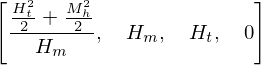

In [6]:
H.vec

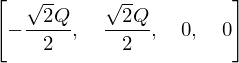

In [7]:
q.vec

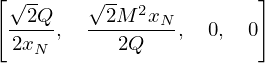

In [8]:
P.vec

In [9]:
sol=sp.solve(zh-2*xb*(P*H)/Q**2,H.m)

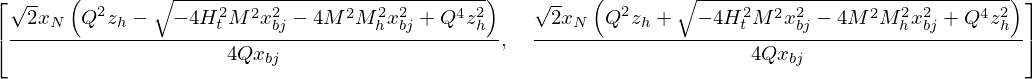

In [10]:
[_.simplify() for _ in sol]

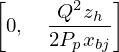

In [11]:
[get_massless(_).simplify()*P.vec[0]/P.p for _ in sol]

# SECTION V

## Eq.30

In [12]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

In [13]:
sol=sp.solve(zh-2*xb*(P*H)/Q**2,zN)

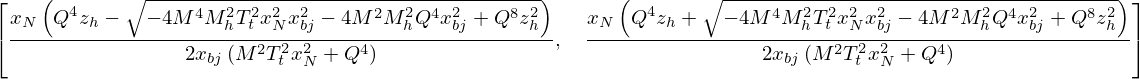

In [14]:
[_.simplify() for _ in sol]

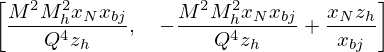

In [15]:
[get_massless(_,n=5) for _ in sol]

## Eq. 32-34

## from breit frame to hadron frame via   B->R->B

In [16]:
H=Vec('H',theta=0)
q=Vec('q',mod=[0,0,0,1],theta=0)
P=Vec('P',mod=[1,0,0,1],theta=0)
V=Vec('V',theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])

q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

In [17]:
T.LC2MC()
H.LC2MC()
q.LC2MC()
P.LC2MC()
V.LC2MC()

T.simplify_vec()
H.simplify_vec()
q.simplify_vec()
P.simplify_vec()
V.simplify_vec()

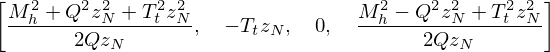

In [18]:
H.vec

In [19]:
q.vec

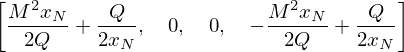

In [20]:
P.vec

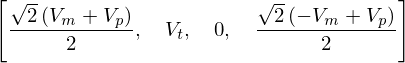

In [21]:
V.vec

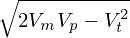

In [22]:
V.get_mass().simplify()

## boost

In [23]:
bP=P.boost(P)
bH=H.boost(P)
bq=q.boost(P)
bV=V.boost(P)


bP.simplify_vec()
bH.simplify_vec()
bq.simplify_vec()
bV.simplify_vec()

In [24]:
bP.vec

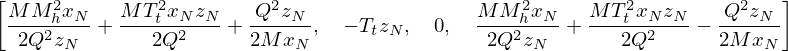

In [25]:
bH.vec

In [26]:
(bH.get_mass()**2).simplify()

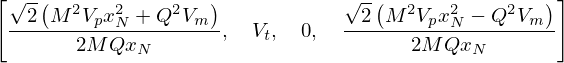

In [27]:
bV.vec

In [28]:
(bV.get_mass()**2).simplify()

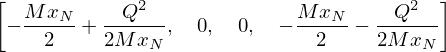

In [29]:
bq.vec

In [30]:
(bq.get_mass()**2).simplify()

## rotation

In [31]:
Z=Vec('Z','MC',[0,0,0,1])
Z.set_z(-1)
cos=bH.get_cos(Z).simplify()
sin=bH.get_sin(Z).simplify()
N=Vec.cross(bH,Z)
N.vec

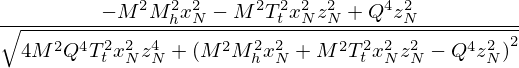

In [32]:
cos

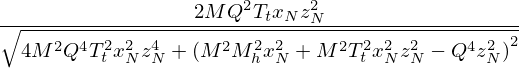

In [33]:
sin

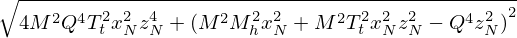

In [34]:
kappa1=sp.symbols('kappa1',positive = True, real = True)
kappa1_val=sp.denom(cos)
kappa1_val

In [35]:
rbP=bP.rotate(N,cos,sin)
rbH=bH.rotate(N,cos,sin)
rbq=bq.rotate(N,cos,sin)
rbV=bV.rotate(N,cos,sin)

rbP.simplify_vec()
rbH.simplify_vec()
rbq.simplify_vec()
rbV.simplify_vec()

In [36]:
rbP.vec

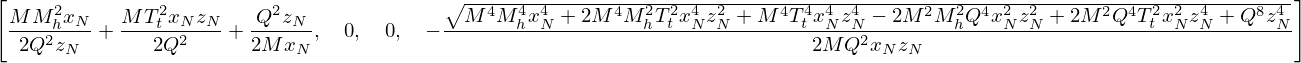

In [37]:
rbH.vec

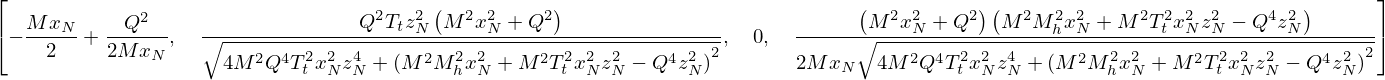

In [38]:
rbq.vec

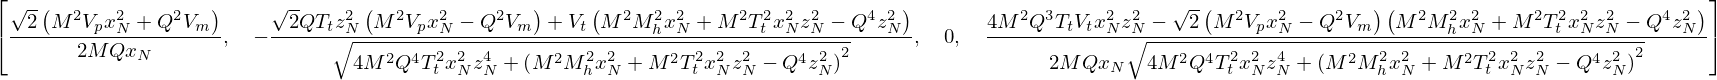

In [39]:
rbV.vec

In [40]:
(rbq.get_mass()**2).simplify()

In [41]:
(rbH.get_mass()**2).simplify()

In [42]:
(rbP.get_mass()**2).simplify()

In [43]:
(rbV.get_mass()**2).simplify()

In [44]:
rbP.subs_vec(kappa1_val,kappa1)
rbH.subs_vec(kappa1_val,kappa1)
rbq.subs_vec(kappa1_val,kappa1)
rbV.subs_vec(kappa1_val,kappa1)

In [45]:
rbP.vec

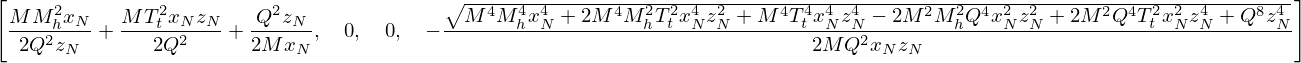

In [46]:
rbH.vec

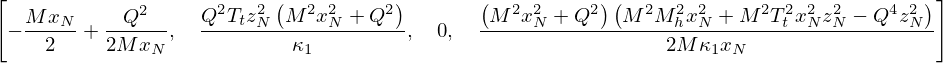

In [47]:
rbq.vec

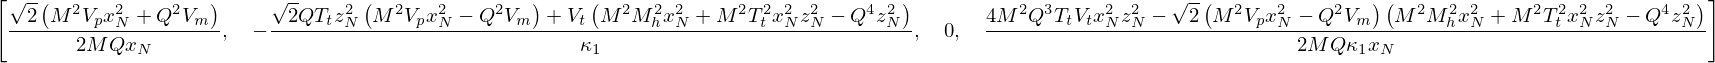

In [48]:
rbV.vec

In [49]:
((rbV.get_mass().subs(kappa1,kappa1_val)**2)).simplify()

## boost

In [50]:
cosh,sinh=Vec.get_boost_CS([rbP.get_E(),rbP.get_z()],[P.get_E(),P.get_z()])

In [51]:
Z=Vec('Z','MC',[0,0,0,1])
Z.set_z(1)
Z.vec

In [52]:
brbP=rbP.boost(Z,cosh,sinh)
brbq=rbq.boost(Z,cosh,sinh)
brbH=rbH.boost(Z,cosh,sinh)
brbV=rbV.boost(Z,cosh,sinh)

brbP.simplify_vec()
brbH.simplify_vec()
brbq.simplify_vec()
brbV.simplify_vec()

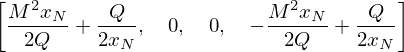

In [53]:
brbP.vec

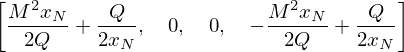

In [54]:
P.vec

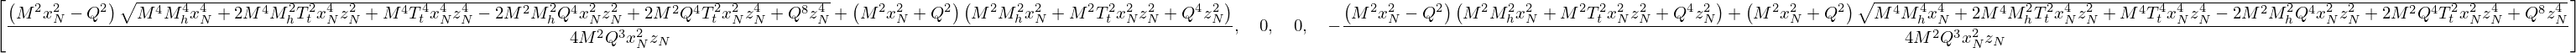

In [55]:
brbH.vec

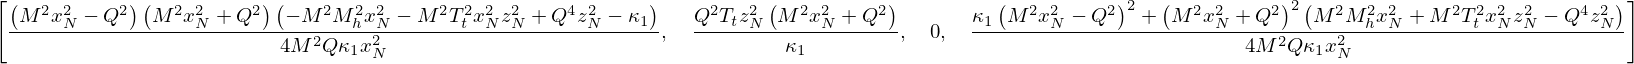

In [56]:
brbq.vec

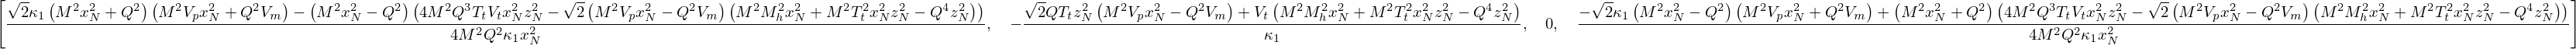

In [57]:
brbV.vec

In [58]:
brbV.MC2LC()

In [59]:
#((brbV.get_mass()**2).subs(kappa1,kappa1_val)).simplify()

In [60]:
((brbP.get_mass()**2).subs(kappa1,kappa1_val)).simplify()

In [61]:
((brbH.get_mass()**2).subs(kappa1,kappa1_val)).simplify()

In [62]:
((brbq.get_mass()**2).subs(kappa1,kappa1_val)).simplify()

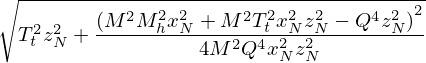

In [63]:
kappa2_val=sp.sqrt((kappa1_val**2/(4*M**2*Q**4*xN**2*zN**2)).simplify())
kappa2_val

In [64]:
kappa2=sp.symbols('kappa',positive = True, real = True)
R=(kappa1_val/kappa2_val).simplify()
R

## Eq. 32

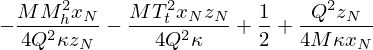

In [65]:
pp=brbV.vec[0].subs(kappa1,R*kappa2)
pp=sp.collect(pp.subs(V.m,0).subs(V.t,0).simplify(),V.p)/V.p
pp

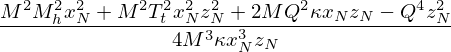

In [66]:
pm=brbV.vec[0].subs(kappa1,R*kappa2)
pm=sp.collect(pm.subs(V.p,0).subs(V.t,0).simplify(),V.m)/V.m
pm

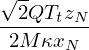

In [67]:
pt=brbV.vec[0].subs(kappa1,R*kappa2)
pt=sp.collect(pt.subs(V.p,0).subs(V.m,0).simplify(),V.t)/V.t
pt

## Eq. 33

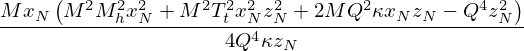

In [68]:
mp=brbV.vec[1].subs(kappa1,R*kappa2)
mp=sp.collect(mp.subs(V.m,0).subs(V.t,0).simplify(),V.p)/V.p
mp

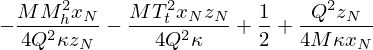

In [69]:
mm=brbV.vec[1].subs(kappa1,R*kappa2)
mm=sp.collect(mm.subs(V.p,0).subs(V.t,0).simplify(),V.m)/V.m
mm

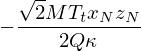

In [70]:
mt=brbV.vec[1].subs(kappa1,R*kappa2)
mt=sp.collect(mt.subs(V.p,0).subs(V.m,0).simplify(),V.t)/V.t
mt

## Eq. 34

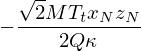

In [71]:
tp=brbV.vec[2].subs(kappa1,R*kappa2)
tp=sp.collect(tp.subs(V.m,0).subs(V.t,0).simplify(),V.p)/V.p
tp

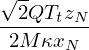

In [72]:
tm=brbV.vec[2].subs(kappa1,R*kappa2)
tm=sp.collect(tm.subs(V.p,0).subs(V.t,0).simplify(),V.m)/V.m
tm

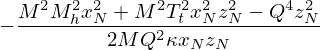

In [73]:
tt=brbV.vec[2].subs(kappa1,R*kappa2)
tt=sp.collect(tt.subs(V.p,0).subs(V.m,0).simplify(),V.t)/V.t
tt

In [74]:
#tp=brbV.vec[3].subs(kappa1,R*kappa2)
#tp=sp.collect(tp.subs(V.m,0).subs(V.t,0).simplify(),V.p)/V.p
#tp

In [75]:
#tm=brbV.vec[3].subs(kappa1,R*kappa2)
#tm=sp.collect(tm.subs(V.p,0).subs(V.t,0).simplify(),V.m)/V.m
#tm

In [76]:
#tt=brbV.vec[3].subs(kappa1,R*kappa2)
#tt=sp.collect(tm.subs(V.p,0).subs(V.m,0).simplify(),V.t)/V.t
#tt

## Eq. 32 from paper

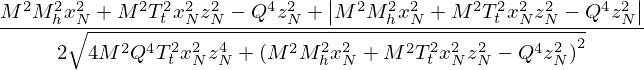

In [77]:
ppr=1/sp.S(2)*(1+sp.sqrt(1-zN**2*T.t**2/kappa2**2))
diff=ppr-pp
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

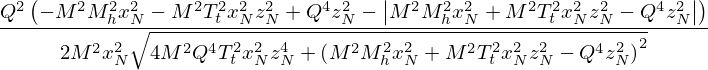

In [78]:
pmr=-Q**2/(sp.S(2)*M**2*xN**2)*(-1+sp.sqrt(1-zN**2*T.t**2/kappa2**2))
diff=pmr-pm
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

In [79]:
ptr=Q*zN*T.t/(sp.sqrt(2)*M*xN*kappa2)
diff=ptr-pt
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

## Eq. 33 from paper

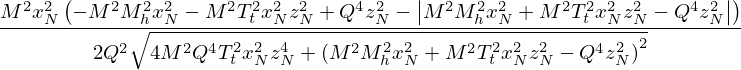

In [80]:
mpr=-M**2*xN**2/(sp.S(2)*Q**2)*(-1+sp.sqrt(1-zN**2*T.t**2/kappa2**2))
diff=mpr-mp
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

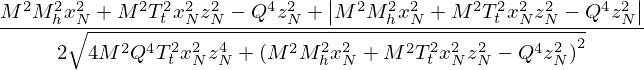

In [81]:
mmr=Q**2/(sp.S(2)*Q**2)*(1+sp.sqrt(1-zN**2*T.t**2/kappa2**2))
diff=mmr-mm
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

In [82]:
mtr=-M*xN*zN*T.t/(sp.sqrt(2)*Q*kappa2)
diff=mtr-mt
diff.simplify()
diff.subs(kappa2,kappa2_val).simplify()

##  Eq. 34 from paper

In [83]:
tpr=-T.t*zN*M**2*xN**2/(sp.sqrt(2)*M*Q*xN*kappa2)
diff=tpr-tp
diff.simplify()

In [84]:
tmr=T.t*zN*Q**2/(sp.sqrt(2)*M*Q*xN*kappa2)
diff=tmr-tm
diff.simplify()

In [85]:
tpr=-T.t*zN*M**2*xN**2/(sp.sqrt(2)*M*Q*xN*kappa2)
diff=tmr-tm
diff.simplify()

## massless limit : Eq. 35,36,37

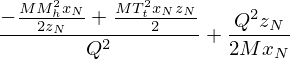

In [86]:
get_massless(kappa2_val,replace=[[kappa2,kappa2_val]])

In [87]:
get_massless(pp,replace=[[kappa2,kappa2_val]])

In [88]:
get_massless(pm,replace=[[kappa2,kappa2_val]])

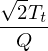

In [89]:
get_massless(pt,replace=[[kappa2,kappa2_val]])

In [90]:
get_massless(mp,replace=[[kappa2,kappa2_val]])

In [91]:
get_massless(mm,replace=[[kappa2,kappa2_val]])

In [92]:
get_massless(mt,replace=[[kappa2,kappa2_val]])

In [93]:
get_massless(tp,replace=[[kappa2,kappa2_val]])

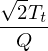

In [94]:
get_massless(tm,replace=[[kappa2,kappa2_val]])

In [95]:
get_massless(tt,replace=[[kappa2,kappa2_val]])

## Eq. 38

In [96]:
brbq.LC2MC()

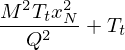

In [97]:
qT=brbq.vec[1].subs(kappa1,R*kappa2)

get_massless(qT,replace=[[kappa2,kappa2_val]])

## Eq. 41

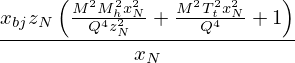

In [98]:
exp=2*xb*(P*H)/Q**2
exp=exp.simplify()
exp=(exp*xN/(xb*zN)).simplify()
exp=(xb*zN/xN)*exp
exp

## Eq. 42

In [ ]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)
H.vec[0]=H.vec[0].subs(zN**2*T.t**2,MhT**2-Mh**2)

In [ ]:
H.vec

In [ ]:
zN2zh=sp.solve(zh-2*xb*(P*H)/Q**2,zN)[1]
zN2zh

# SECTION VI

## For next Eqs we need form in the path

In [ ]:
def process(code):
    
    code=[l+'\n' for l in code]
    F=open('code.frm','w')
    F.writelines(code)
    F.close()
    cmd=['form','code.frm']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    out=p.communicate()
    out=[l for l in out[0].split('\n') if l!='' if 'sec out of' not in l if ';' not in l if 'FORM' not in l]

    
    IDX=[i for i in range(len(out)) if '[' and ']' in out[i]]
    IDX.append(len(out))
    data={}
    for i in range(len(IDX)-1):
        current=IDX[i]
        next=IDX[i+1]
        label=out[current].replace('=','').strip().replace('[','').replace(']','')
        data[label]=''
        for j in range(current+1,next): data[label]+=out[j].strip().replace('&','').replace(' ','')
        #data[label]=data[label].replace('sqrt_','sqrt')
        #data[label]=data[label].replace('xn','(x_n)')    

    
    return data

In [ ]:
aem=sp.symbols('alpha_em',positive = True, real = True)
y=sp.symbols('y',positive = True, real = True)
s=sp.symbols('s',positive = True, real = True)
F1=sp.symbols('F_1', real = True)
F2=sp.symbols('F_2', real = True)
FT=sp.symbols('F_T', real = True)
FL=sp.symbols('F_L', real = True)
xb=sp.symbols('x_bj',positive = True, real = True)
xN=sp.symbols('x_N',positive = True, real = True)
zh=sp.symbols('z_h',positive = True, real = True)
zN=sp.symbols('z_N',positive = True, real = True)
Q=sp.symbols('Q',positive = True, real = True)
M=sp.symbols('M',positive = True, real = True)
Mh=sp.symbols('M_h',positive = True, real = True)
qt=sp.S('q_t')
eps=sp.symbols('epsilon', real = True)
gam=sp.symbols('gamma', real = True)

## Eq. 53

In [ ]:
code=[]

#--headers
code.append(r'Off Statistics;')
code.append(r'.sort;')
code.append(r'Index mu,nu;')
code.append(r'Vector P,q,l,lp;')
#code.append(r'Symbols A,B;')
code.append(r'Symbols M,Q,x,y;')
code.append(r'CFunction F1,F2;')
code.append(r'Symbols n;')

code.append(r'Local [L]   = 2*(l(mu)*lp(nu)+l(nu)*lp(mu)-d_(mu,nu)*l.lp);')
code.append(r'Local [P1]  = -d_(mu,nu)+q(mu)*q(nu)/q.q;')
code.append(r'Local [P2]  = (P(mu)-q(mu)*P.q/q.q)*(P(nu)-q(nu)*P.q/q.q)/P.q;')
code.append(r'Local [W]   = [P1]*F1 + [P2]*F2;')
code.append(r'Local [LW]  = [L]*[W];')

#code.append(r'repeat;')
#code.append(r'endrepeat;')
code.append(r'id q=l-lp;')
code.append(r'id P.P=M^2;')
code.append(r'id l.l=0;')
code.append(r'id lp.lp=0;')
code.append(r'id q.q^n?=(-Q^2)^n;')
code.append(r'id P.q^n?=(Q^2/(2*x))^n;')
code.append(r'id l.lp=Q^2/2;')
code.append(r'id lp=l-q;')
code.append(r'id P.l=P.q/y;')
code.append(r'id P.q^n?=(Q^2/(2*x))^n;')
code.append(r'.sort;')

#--prints
code.append(r'format fortran;')
code.append(r'Print [LW];')
code.append(r'.end;')

In [ ]:
out=process(code)
print(out)

In [ ]:
LW=parse_expr(out['LW'])
LW=LW.subs('x',xb).subs('y',y).subs('Q',Q).subs('F1',F1).subs('F2',F2).subs('M',M)
LW

In [ ]:
sigma12= aem**2*y/(4*Q**4*zN) * LW
sigma12

### second line

In [ ]:
NC2=sigma12.subs(F1,0).subs(F2,1).simplify()
NC1=sigma12.subs(F1,1).subs(F2,0).simplify()
C2=(1-y-xb**2*y**2*M**2/Q**2)
N=(NC2/C2).simplify()
C1=(NC1/N).simplify()

In [ ]:
N

In [ ]:
C1

### third line

In [ ]:
sigma2L=sigma12.subs(F1,(1+4*M**2*xb**2/Q**2)*F2/(2*xb)-FL/(2*xb))
sigma2L

In [ ]:
NC2=sigma2L.subs(FL,0).subs(F2,1).simplify()
NCL=sigma2L.subs(FL,1).subs(F2,0).simplify()
C2=(1+(1-y)**2+2*xb**2*y**2*M**2/Q**2)
N=(NC2/C2).simplify()
CL=(NCL/N).simplify()

In [ ]:
N

In [ ]:
CL

### forth line

In [ ]:
sigmaLT=sigma12.subs(F2,(FL+FT)/(1+4*M**2*xb**2/Q**2)).subs(F1,FT/(2*xb))
sigmaLT.simplify()

In [ ]:
NCT=sigmaLT.subs(FL,0).subs(FT,1).simplify()
NCL=sigmaLT.subs(FL,1).subs(FT,0).simplify()
CT=1
N=(NCT/CT).simplify()
CL=(NCL/N).simplify()

In [ ]:
CL

In [ ]:
eps_val=CL.subs(M,gam*Q/(2*xb)).simplify()
eps_val

In [ ]:
N_val=N.subs(M,gam*Q/(2*xb)).simplify()

In [ ]:
N_val*=(1-eps_val)/(1-eps)
N_val.simplify()

## Jac in Eq. 58 

In [ ]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)
H.vec[0]=H.vec[0].subs(zN**2*T.t**2,MhT**2-Mh**2)
zN2zh=sp.solve(zh-2*xb*(P*H)/Q**2,zN)[1]
zN2zh

In [ ]:
jac=sp.diff(zN2zh,zh)
jac.simplify()

In [ ]:
exp=xN*(sp.sqrt(1-(4*M**2*xb**2*MhT**2)/Q**4/zh**2)+1)
exp/=2*xb*sp.sqrt(1-(4*M**2*xb**2*MhT**2)/Q**4/zh**2)
exp.simplify()

## Eq. 61, 62

In [ ]:
code=[]

code.append(r'Off Statistics;')
code.append(r'.sort;')
code.append(r'Index mu,nu;')
code.append(r'Vector P,q,Pplus,Pt;')
code.append(r'Symbols A,B;')
code.append(r'Symbols M,Q,xN;')
code.append(r'CFunction F1,F2;')
code.append(r'Symbols n;')

#--setup invariants
code.append(r'Local [P.P]  = P(1)*P(2)+P(2)*P(1);')
code.append(r'Local [P.q]  = P(1)*q(2)+P(2)*q(1);')
code.append(r'id P(1)=Pplus;')
code.append(r'id P(2)=M^2/2/Pplus;')
code.append(r'id q(1)=-xN*Pplus;')
code.append(r'id q(2)=Q^2/2/xN/Pplus;')
code.append(r'id Pplus=(Q/sqrt_(2)/xN);')
code.append(r'id 1/Pplus=1/(Q/sqrt_(2)/xN);')
code.append(r'.sort;')


#--compute projections
code.append(r'Local [W1]  = -d_(mu,nu)+q(mu)*q(nu)/q.q;')
code.append(r'Local [W2]  = (P(mu)-q(mu)*P.q/q.q)*(P(nu)-q(nu)*P.q/q.q)/P.q;')
code.append(r'Local [Pg]  = d_(mu,nu);')
code.append(r'Local [Ppp] = P(mu)*P(nu);')
code.append(r'Local [P]   = A*[Pg] + B*[Ppp];')
code.append(r'Local [PW1] = [P]*[W1];')
code.append(r'Local [PW2] = [P]*[W2];')
code.append(r'id P.P=[P.P];')
code.append(r'id q.q^n?=(-Q^2)^n;')
code.append(r'id P.q^n?=([P.q])^n;')
code.append(r'.sort;')


#--compute projections
code.append(r'id P.P=[P.P];')
code.append(r'id P.q^n?=([P.q])^n;')
code.append(r'id q.q^n?=(-Q^2)^n;')
code.append(r'.sort;')


#--prints
code.append(r'format fortran;')
code.append(r'Print [PW1];')
code.append(r'Print [PW2];')

code.append(r'.end;')

In [ ]:
out=process(code)

In [ ]:
out['PW1']

In [ ]:
A,B=sp.symbols('A,B')
PW1=sp.nsimplify(parse_expr(out['PW1'])).simplify()
PW1=PW1.subs('xN',xN).subs('A',A).subs('B',B)
PW1=PW1.subs('Q',Q).subs('M',M)

PW2=sp.nsimplify(parse_expr(out['PW2'])).simplify()
PW2=PW2.subs('xN',xN).subs('A',A).subs('B',B)
PW2=PW2.subs('Q',Q).subs('M',M)

In [ ]:
PW1

In [ ]:
PW2

In [ ]:
P1=sp.solve([PW1-1,PW2-0],A,B)
P1[A]=sp.factor(P1[A])
P1[B]=sp.factor(P1[B])
P1

In [ ]:
P1[A]=get_massless(P1[A])
P1[B]=get_massless(P1[B])
P1

In [ ]:
P2=sp.solve([PW1-0,PW2-1],A,B)
P2[A]=sp.factor(P2[A])
P2[B]=sp.factor(P2[B])
P2

In [ ]:
P2[A]=get_massless(P2[A])
P2[B]=get_massless(P2[B])
P2

## Eq. 64

In [ ]:
jac=sp.diff(zN2zh,zh)
exp=aem**2*y/(4*zN*xb*Q**2*(1-eps)) * jac * (FT+eps*FL)
exp=exp.subs(FL,FL/(jac/(4*zN)/(1+gam**2/(2*xb))))
exp=exp.subs(FT,FT/(jac/(4*zN)/(1+gam**2/(2*xb))))
exp.simplify()

In [ ]:
sp.diff(zN2zh,zh)

## Eq. 68-69

In [ ]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)
#H.vec[0]=H.vec[0].subs((zN*T.t)**2,MhT**2-Mh**2)

In [ ]:
H.vec

In [ ]:
W=P+q-H
W.get_sqmass().simplify()

In [ ]:
xN2xb=sp.solve(xb-Q**2/(2*P*q),xN)[0]
xN2xb=xN2xb*(Q+sp.sqrt(Q**2+4*M**2*xb**2))
xN2xb=xN2xb.expand()
xN2xb/=(Q+sp.sqrt(Q**2+4*M**2*xb**2))
xN2xb

In [ ]:
W=P+q
W2=W.get_sqmass()
W2=W2.expand()
W2=W2.subs(xN,xN2xb).expand().simplify().expand()
W2

In [ ]:
Pq=P+q
exp=-2*(Pq*H)
exp=exp.subs(zN,zN2zh)
exp=exp.subs(xN,xN2xb)

exp=exp.simplify()
den=sp.denom(exp)
num=sp.numer(exp)

dum=(Q-sp.sqrt(4*M**2*xb**2+Q**2))*(Q**2*zh-sp.sqrt(-4*M**2*MhT**2*xb**2+Q**4*zh**2))
den=(den*dum).expand()
num=(num*dum).expand()
exp=num/den
exp=exp.simplify().expand()
exp

In [ ]:
sp.series(exp,M,0,1)

##  Eq. 70

In [ ]:
get_massless(xN2xb,n=6)

## Eq. 71

In [ ]:
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)
H.vec[0]=H.vec[0].subs(zN**2*T.t**2,MhT**2-Mh**2)

In [ ]:
zN2zh=sp.solve(zh-2*xb*(P*H)/Q**2,zN)[1]
zN2zh

In [ ]:
exp=zN2zh.subs(MhT**2,Mh**2+H.t**2)
exp=exp.subs(xN,xN2xb)
exp=get_massless(exp,n=10)/zh
exp=exp.expand()
exp

In [ ]:
paper=1-xb**2*M**2/Q**2*(1+H.t**2/zh**2/Q**2)\
      +(xb**2*M**2/Q**2)**2*(H.t**2/zh**2/Q**2-H.t**4/zh**4/Q**4+2-Mh**2/zh**2/M**2/xb**2)

paper=paper.expand()
paper

In [ ]:
diff=(exp-paper).expand().subs(1/Q**8,0)
diff

# SECTION VIII

In [ ]:
xb=sp.symbols('x_bj',positive = True, real = True)
xN=sp.symbols('x_N',positive = True, real = True)
zh=sp.symbols('z_h',positive = True, real = True)
zN=sp.symbols('z_N',positive = True, real = True)
Q=sp.symbols('Q',positive = True, real = True)
M=sp.symbols('M',positive = True, real = True)
Mh=sp.symbols('M_h',positive = True, real = True)
Mki=sp.symbols('M_ki',positive = True, real = True)
Mkf=sp.symbols('M_kf',positive = True, real = True)
Mx=sp.symbols('M_x',positive = True, real = True)

MhT=sp.symbols('M_hT',positive = True, real = True)
qt=sp.S('q_t')
eps=sp.S('epsilon')
xi=sp.symbols('xi',positive = True, real = True)
zeta=sp.symbols('zeta',positive = True, real = True)
hxN=sp.symbols('\hat{x}_N',positive = True, real = True)
hzN=sp.symbols('\hat{z}_h',positive = True, real = True)

In [ ]:
ki=Vec('k_i','LC',theta=0)
kf=Vec('k_f','LC',theta=0)
kx=Vec('k_x','LC',theta=0)

q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
H=Vec('H','LC',theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
dk=Vec('delta_k',theta=0,mod=[0,0,1,1])

q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

ki.set_plus((xN/hxN)*P.vec[0])
kf.set_minus(H.vec[1]/(zN/hzN))
kf.set_perp((-hzN*T+dk).vec[2:])

ki.change_minus(Mki)
kf.change_plus(Mkf)

In [ ]:
dk.vec

In [ ]:
ki.vec

In [ ]:
kf.vec

In [ ]:
kx=ki+q-kf
kx.simplify_vec()
kx.vec=[_.subs(Mkf,0).subs(Mki,0).subs(ki.t,0) for _ in kx.vec]
Mx2_val=kx.get_sqmass()
kx.vec

In [ ]:
Mx2_val

In [ ]:
sol=sp.solve(Mx**2-Mx2_val.subs(dk.t,0),hzN)
len(sol)

In [ ]:
sol[0].subs(Mx,0).subs(kf.t,0).subs(dk.t,0).simplify()

In [ ]:
hzN_val=sol[0]
hzN_val.simplify()

## Eqs.86-88

In [ ]:
k=kf-q
k.vec

### Eq. 86

In [ ]:
exp=k.vec[0].subs(hzN,hzN_val)
exp=exp.subs(Mkf,0).subs(dk.t,0)
exp=exp.simplify()
exp.expand().simplify()

In [ ]:
paper=Q/sp.sqrt(2)*(1+(T.t/Q)**2*(1-hxN*(1+(Mx/Q)**2))/(1-hxN*(1-(T.t/Q)**2)))
paper

In [ ]:
(exp-paper).simplify()

In [ ]:
get_massless(exp/Q*sp.sqrt(2)).simplify()

### Eq. 87

In [ ]:
exp=k.vec[1].subs(hzN,hzN_val)
exp=exp.subs(Mkf,0)
exp=exp.simplify()
exp.expand().simplify()

In [ ]:
paper=-Q/sp.sqrt(2)*(1-(1-hxN*(1+(Mx/Q)**2))/(1-hxN*(1-(T.t/Q)**2)))
paper

In [ ]:
(exp-paper).simplify()

In [ ]:
get_massless(-exp/Q*sp.sqrt(2)/hxN*(1-hxN)).simplify()

### Eq. 88

In [ ]:
exp=k.vec[2].subs(hzN,hzN_val).subs(dk.t,0)
exp=exp.subs(Mkf,0)
exp=exp.simplify()
exp.expand().simplify()

In [ ]:
paper=-Q*(T.t/Q)*(1-hxN*(1+(Mx/Q)**2))/(1-hxN*(1-(T.t/Q)**2))
paper

In [ ]:
(exp-paper).simplify()

In [ ]:
get_massless(exp).simplify().expand().simplify()

## eq. 92-95

In [ ]:
R1=(H*kf)/(H*ki)
R1.simplify()

In [ ]:
R2=(k.get_sqmass()/Q**2).expand()
R2

In [ ]:
R3=(kx.get_sqmass()/Q**2).expand()
R3

In [ ]:
k*q

# SECTION IX

In [ ]:
ki=Vec('k_i','LC',theta=0)
kf=Vec('k_f','LC',theta=0)
kx=Vec('k_x','LC',theta=0)

q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
H=Vec('H','LC',theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
dk=Vec('delta_k',theta=0,mod=[0,0,1,1])

q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)
H.vec[0]=H.vec[0].subs(Mh**2,MhT**2-zN**2*T.t**2)

ki.set_plus((xN/hxN)*P.vec[0])
kf.set_minus(H.vec[1]/(zN/hzN))
kf.set_perp((-hzN*T+dk).vec[2:])

ki.change_minus(Mki)
kf.change_plus(Mkf)

dy=sp.symbols('Delta_y')

In [ ]:
dy

In [ ]:
H.vec

## Eq. 98

In [ ]:
yp=1/sp.S(2)*sp.log(P.vec[0]/P.vec[1]).simplify()
yp

In [ ]:
yh=1/sp.S(2)*sp.log(H.vec[0]/H.vec[1]).simplify()
yh

## Eq. 101

In [ ]:
dy_val=(yp-yh).simplify()
dy_val

In [ ]:
sp.solve(dy-dy_val,zN)

## Eq. 102

In [ ]:
sol=sp.solve(zh-2*xb*(P*H)/Q**2,zN)
sol

In [ ]:
Lyh=sp.exp(yh)
Lyh=Lyh.subs(zN,sol[0])
Lyh=Lyh.subs(xN,xN2xb)
#get_massless(Lyh).simplify()
num=sp.numer(Lyh)
den=sp.denom(Lyh)
A=Q**2*zh
B=den-A
den=den*(A-B)
den=den.expand()
Lyh=num*(A-B)/den
lprint(Lyh)
lprint(get_massless(Lyh).simplify())

In [ ]:
Lyh=sp.exp(yh)
Lyh=Lyh.subs(zN,sol[1])
Lyh=Lyh.subs(xN,xN2xb)
#get_massless(Lyh).simplify()
num=sp.numer(Lyh)
den=sp.denom(Lyh)
A=Q**2*zh
B=den-A
den=den*(A-B)
den=den.expand()
Lyh=num*(A-B)/den
lprint(Lyh)
lprint(get_massless(Lyh).simplify())

## Eq. 103

In [ ]:
yi=1/sp.S(2)*sp.log(ki.vec[0]/ki.vec[1])
lprint(yi)
get_massless(yi).simplify()

In [ ]:
yf=1/sp.S(2)*sp.log(kf.vec[0]/kf.vec[1]).simplify()
lprint(yf)
lprint(yf.subs(Mkf,0).subs(dk.t,0))
lprint(yf.subs(T.t,0))

## Eq. 104

In [ ]:
ki.vec

In [ ]:
kf.vec

In [ ]:
q.vec

# SECTION X

In [ ]:
xh=sp.symbols('x_h',positive = True, real = True)
dy=sp.symbols('Delta_y',positive = True, real = True)
H=Vec('H','LC',theta=0)
q=Vec('q','LC',mod=[1,1,0,0],theta=0)
P=Vec('P','LC',mod=[1,1,0,0],theta=0)
T=Vec('T',theta=0,mod=[0,0,1,1])
q.set_plus(-Q/sp.sqrt(2))
q.set_minus(Q/sp.sqrt(2))
P.set_plus(Q/xN/sp.sqrt(2))
P.set_minus(xN*M**2/sp.sqrt(2)/Q)
H.set_minus(zN*q.vec[1])
H.set_perp((-zN*T).vec[2:])
H.change_plus(Mh)

In [ ]:
sol=sp.solve(xh-(q*H)/(P*q),zN)
sol=[_.simplify() for _ in sol]
sol

In [ ]:
get_massless(sol[0])

In [ ]:
get_massless(sol[1])

## Eq. 106

In [ ]:
exp=sol[1]
exp=exp.subs(xN,xN2xb)
exp=exp.subs(M,0)
exp=exp.simplify()
exp

In [ ]:
get_massless(exp,n=10)

## Eq. 107

In [ ]:
dy_val=yp-yh
dy_val=dy_val.simplify()
dy_val

In [ ]:
zN_val=sp.solve(dy-dy_val,zN)[0]
zN_val

In [ ]:
exp=H*P
exp=exp.subs(Mh**2,MhT**2-zN**2*T.t**2)
exp=exp.subs(zN,zN_val)
exp.simplify()

In [ ]:
exp=H*P
#exp=exp.subs(Mh**2,MhT**2-zN**2*T.t**2)
exp=exp.subs(xN,xN2xb)
exp.simplify()